# Responsible and Explainable AI 
TP 1 –Données Tabulaires

*Erwan DAVID - Guillaume FAYNOT*

# Analyse du jeu de données

In [3]:
import pickle
import shap
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, confusion_matrix # change 2025
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy import stats
import optuna
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, s, f

In [4]:
df = pd.read_pickle('./dataset_RH.pkl')

In [5]:
X = df[0]
y=df[1]
df=X.copy()
df['demission']=pd.DataFrame(y)

In [6]:
display(X)

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
0,Production,8.510000,7.900000,0.910000,0.970000,27,30,1,1,3199,Marié(e),0,32
1,Production,35.119999,22.690001,14.830000,16.299999,7,45,1,2,3861,Marié(e),1,1890
2,Production,25.299999,22.139999,17.309999,17.790001,28,49,1,2,4324,PACS,1,1847
3,Production,5.240000,5.100000,1.020000,1.750000,27,24,0,1,2641,Célibataire,0,2619
4,Production,35.919998,22.840000,8.050000,9.000000,7,46,1,2,5072,Marié(e),1,1963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23852,Support,6.140000,4.750000,11.430000,12.560000,28,35,1,1,2966,Marié(e),0,2210
23853,Support,5.510000,4.780000,1.800000,2.430000,28,28,1,1,3044,Marié(e),0,1318
23854,Production,6.710000,4.790000,10.430000,16.100000,19,47,1,1,3523,Marié(e),0,1932
23855,Support,17.510000,4.470000,13.400000,14.050000,2,35,1,1,3175,Marié(e),0,2014


In [7]:
print(y)

[0 0 0 ... 0 0 0]


Les valeurs de y sont comprises entre 0 et 1, on travaille donc sur un problème de classification binaire

### Missing Values

In [8]:
missing_values = X.isnull().sum()
print(missing_values)

Famille d'emploi                0
Dernière promotion (mois)       0
Dernière augmentation (mois)    0
Début de contrat (années)       0
Ancienneté groupe (années)      0
Etablissement                   0
Âge (années)                    0
Parent                          0
Niveau hiérarchique             0
Salaire (Euros)                 0
Statut marital                  0
Véhicule                        0
matricule                       0
dtype: int64


Le dataset ne présente pas de valeurs manquantes

Aussi, la colonne matricule n'est pas utilie, on préfère utiliser l'index du dataframe (les données sont de toutes manières anonymisées)

### Statistiques et distribution

Affichons les informations statistiques sur le datatset, ainsi que la distribution des valeurs de chaque colonne

In [9]:
X=X.drop(columns="matricule")
X.describe()

,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Véhicule
count,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000
mean,29.460739,7.934986,7.530322,11.632095,20.193947,41.767154,0.720711,1.554554,4168.404032,0.506853
std,25.497874,7.549982,5.985476,9.218618,9.295469,11.014444,0.448659,0.657887,1657.829824,0.500299
min,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,1.000000,2134.000000,0.000000
25%,10.590000,3.180000,2.300000,3.800000,11.000000,34.000000,0.000000,1.000000,3197.000000,0.000000
50%,21.219999,5.880000,6.280000,9.870000,26.000000,41.000000,1.000000,1.000000,3629.000000,1.000000
75%,41.400002,10.340000,11.070000,16.320000,28.000000,49.000000,1.000000,2.000000,4511.000000,1.000000
max,152.970001,84.050003,33.119999,45.619999,36.000000,100.000000,1.000000,4.000000,18137.000000,2.000000


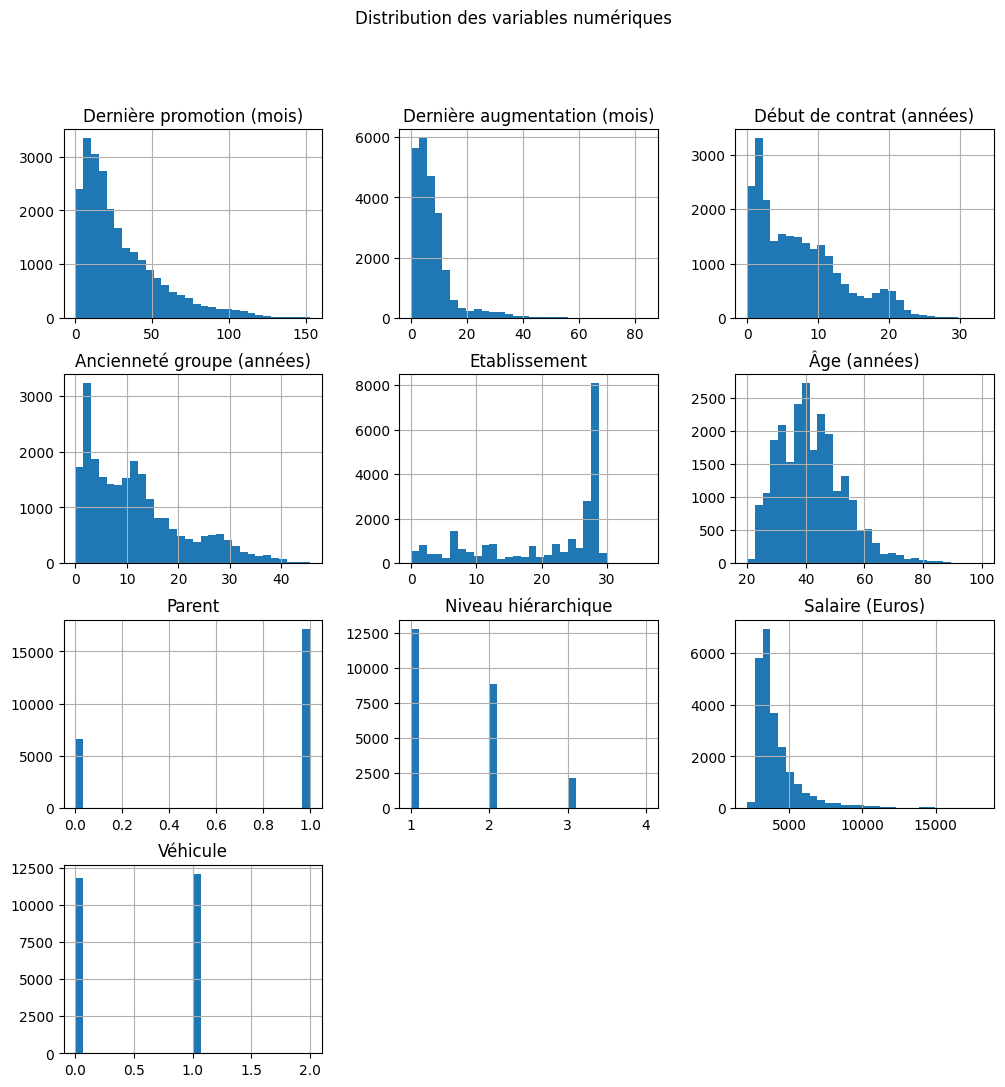

In [10]:
cat_columns = X.select_dtypes(include=['object', 'category']).columns
num_columns = X.select_dtypes(include=['number']).columns

# Histogramme des variables numériques
X.hist(figsize=(12, 12), bins=30)
plt.suptitle("Distribution des variables numériques")
plt.show()

**Dernière promotion (mois) et Dernière augmentation (mois)**
   - La majorité des employés ont reçu leur dernière promotion/augmentation récemment (env. 12 mois).
   - Peu d’employés ont attendu longtemps avant d'obtenir une promotion/augmentation (env. 36 mois).

**Début de contrat (années) et Ancienneté dans le groupe (années)**
   - Une forte concentration de nouveaux employés (0-10 ans), avec un déclin progressif.
   - Cela pourrait indiquer un taux de renouvellement élevé du personnel.

**Âge (années)**
   - Une forte concentration des employés entre 30 et 50 ans, avec une minorité plus jeune

**Établissement**
   - Il y a des pics à différentes valeurs, ce qui peut refléter plusieurs établissements de tailles différentes.

**Niveau hiérarchique**
   - Majorité à un faible niveau hiérarchique

**Salaire (Euros)**
   - La majorité des salaires se situent entre 2 000 et 6 000 euros.
   - Une minorité d'employés touche des salaires très élevés.

**Véhicule**
   - Equirépartition, avec 4 outliers (2)?

C:\Users\guill\AppData\Local\Temp\ipykernel_28312\1217157250.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\guill\AppData\Local\Temp\ipykernel_28312\1217157250.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
C:\Users\guill\AppData\Local\Temp\ipykernel_28312\1217157250.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


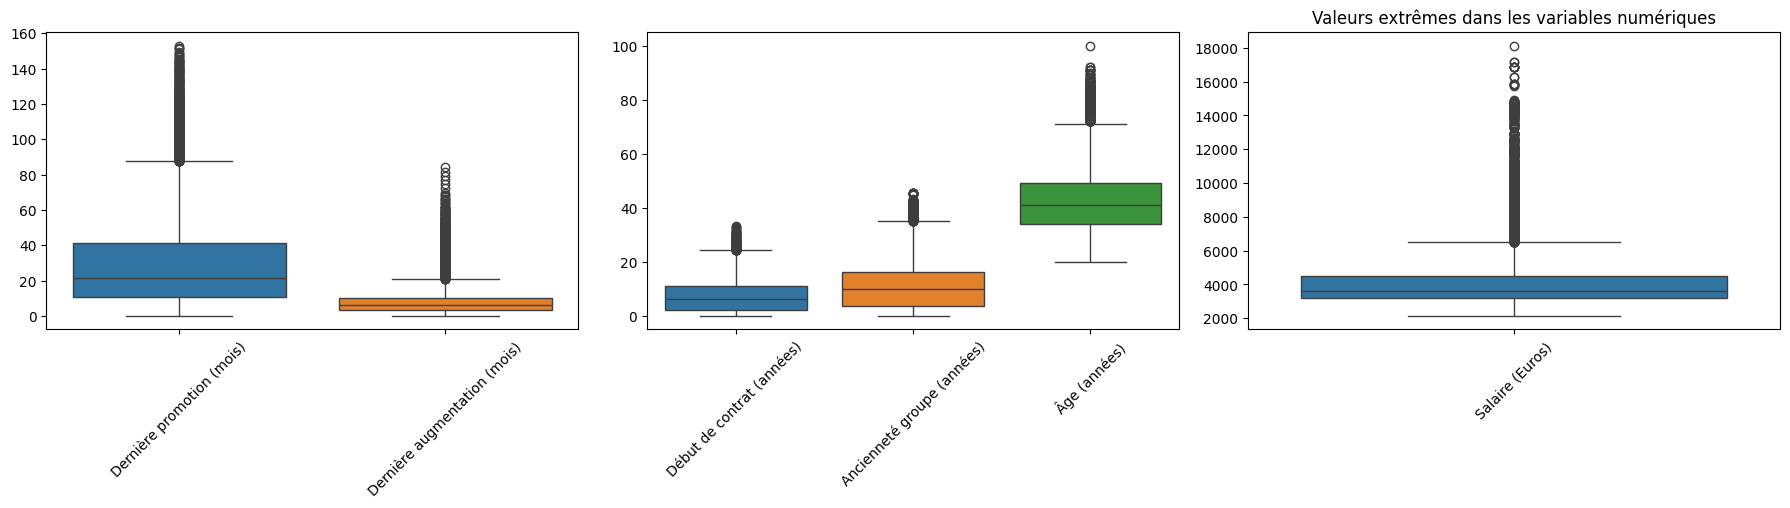

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

num_columns = ['Dernière promotion (mois)', 'Dernière augmentation (mois)']
sns.boxplot(data=X[num_columns], ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

num_columns = ['Début de contrat (années)', 'Ancienneté groupe (années)', 'Âge (années)']
sns.boxplot(data=X[num_columns], ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

num_columns = ['Salaire (Euros)']
sns.boxplot(data=X[num_columns], ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.title("Valeurs extrêmes dans les variables numériques")
plt.show()

### Corrélation

Analysons la corrélation entre les features numériques

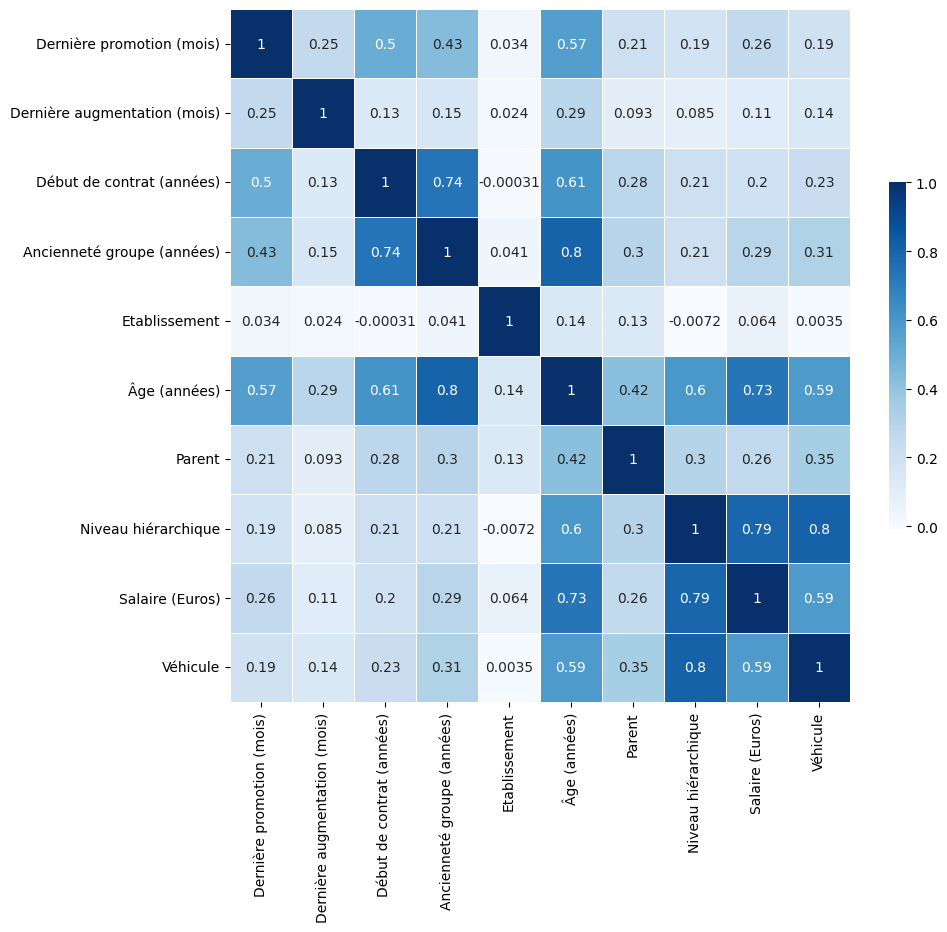

In [12]:
corr = X._get_numeric_data().corr()
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.gcf().set_size_inches(10, 9)

Rien de bien intéressant ici : les plus agés sont ceux qui ont le plus d'ancienneté, etc. Ils sont également aux plus hauts postes hiérarchiques et les mieux payés (et ils ont un véhicule)

### Distributions Démission VS non démission

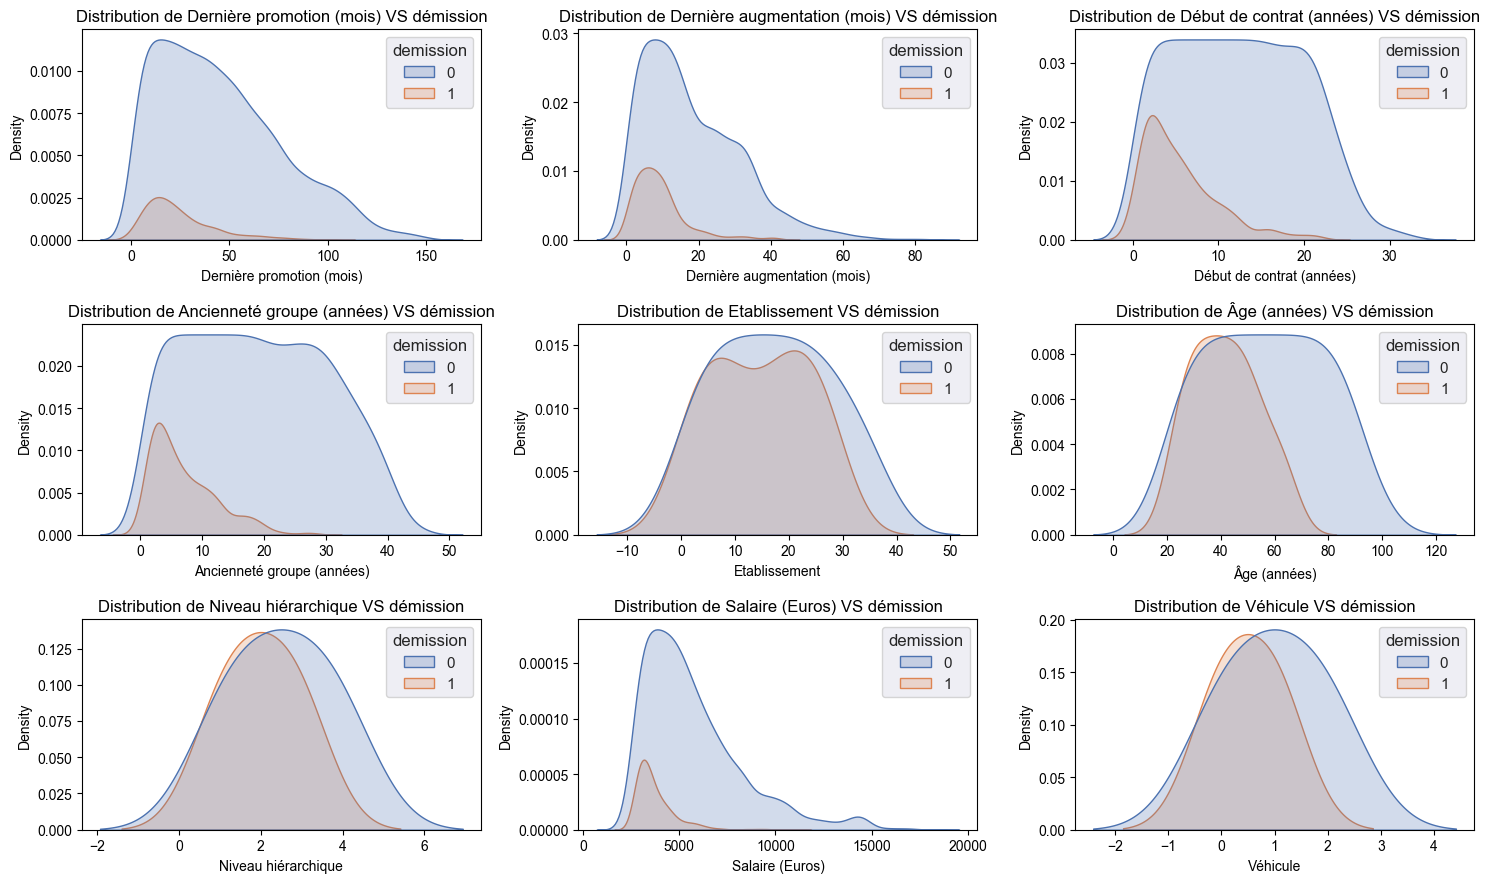

In [13]:
num_columns = X.select_dtypes(include=['number']).columns
num_columns=[x for x in num_columns if x != 'Parent']

fig, axes = plt.subplots((len(num_columns) + 2) // 3, 3, figsize=(15, 3 * ((len(num_columns) + 2) // 3)))

for i, x in enumerate(num_columns):
    sns.set_theme()
    data = df.groupby(x)["demission"].value_counts(normalize=True).mul(100).rename("percentage").reset_index()
    sns.kdeplot(data=data, x=x, hue="demission", fill=True, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Distribution de {x} VS démission')

# Remove any empty subplots
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

Ancienneté dans le groupe & Début de contrat (années)
- Les démissionnaires ont souvent une ancienneté faible à moyenne (0-10 ans).
- Peu d’employés très anciens (10+ ans) démissionnent.

Âge (années)
- La distribution est similaire entre démissionnaires et non-démissionnaires, mais centrée autour de 25-35 ans pour les démissionnaires.

Salaire (Euros)
- Les démissionnaires sont principalement dans la fourchette de salaires bas à intermédiaires (2500 - 5000 euros).
- Très peu de démissions chez les hauts salaires.
    Conclusion : Un salaire plus faible peut être un facteur de démission.

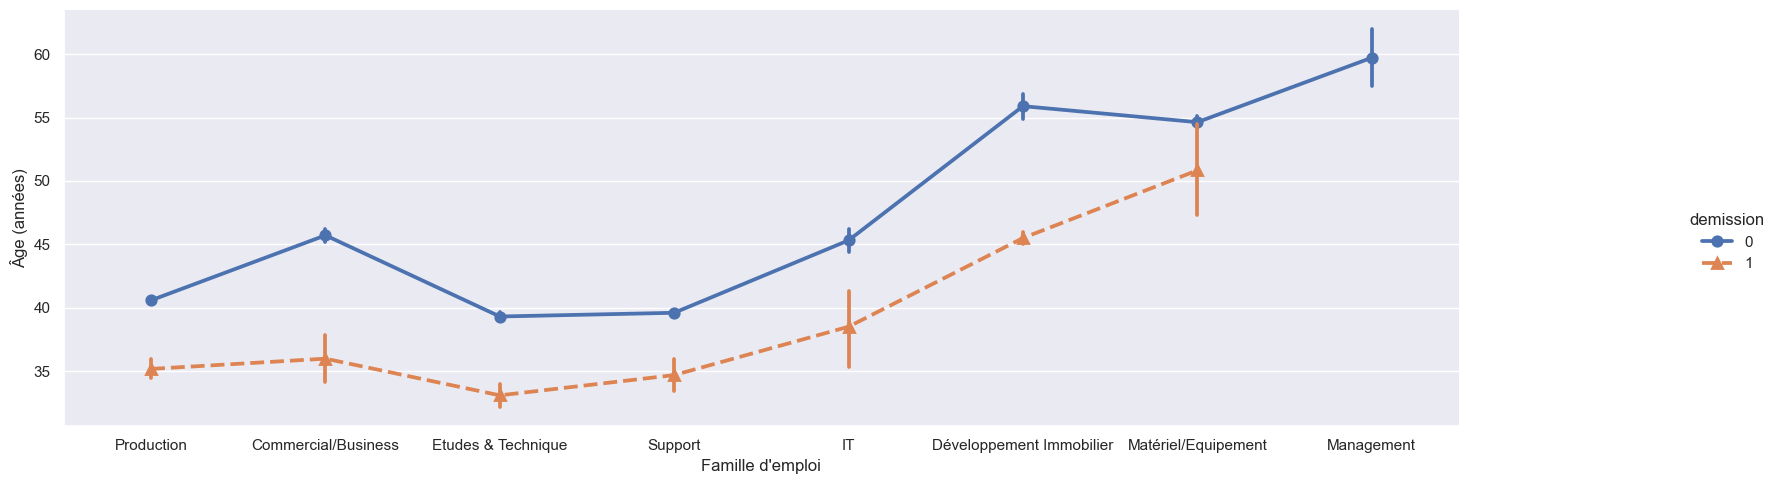

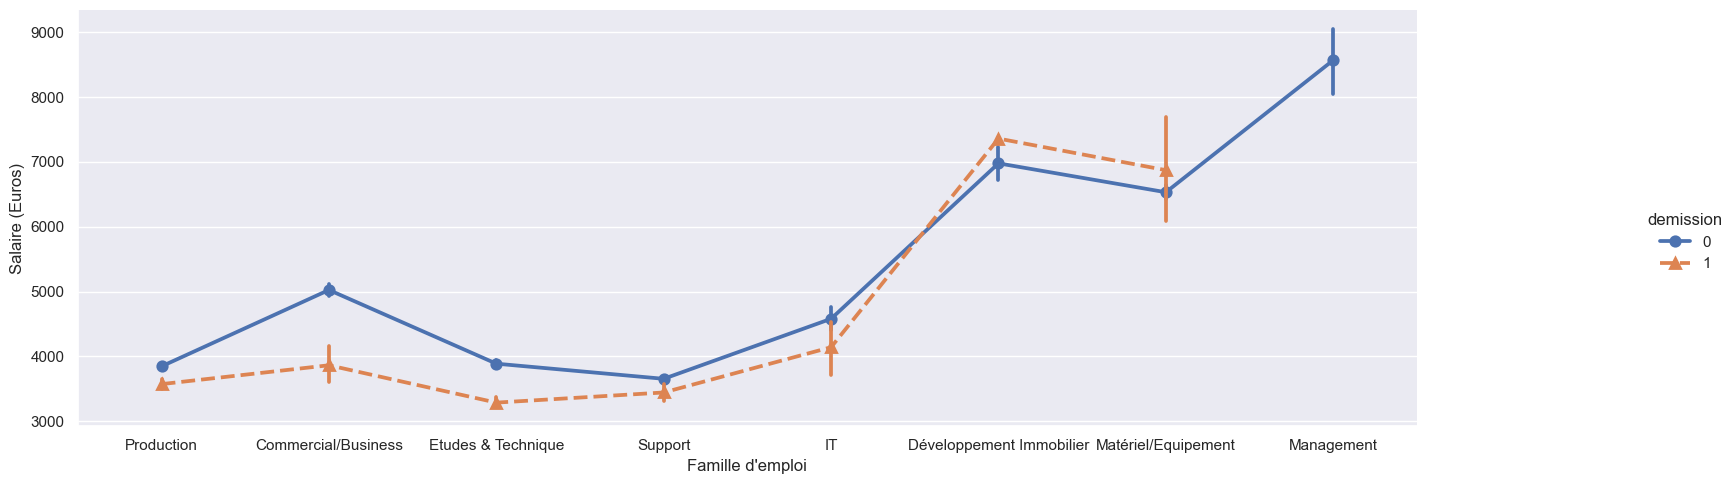

In [14]:
g = sns.catplot(
    data=df, x="Famille d'emploi", y="Âge (années)", hue="demission",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = X['Famille d\'emploi'].unique())
g.set_xticklabels(X['Famille d\'emploi'].unique())
plt.gcf().set_size_inches(20, 5)
g = sns.catplot(
    data=df, x="Famille d'emploi", y="Salaire (Euros)", hue="demission",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = X['Famille d\'emploi'].unique())
g.set_xticklabels(X['Famille d\'emploi'].unique())
plt.gcf().set_size_inches(20, 5)

- Les employés qui démissionnent sont en moyenne 5 à 10 ans plus jeunes que ceux qui restent, avec une forte variabilité pour l'IT et Equipement/Matériel. 
- Les managers sont les plus agés et ne démissionnent pas (peu?)
- Le salaire de ceux qui démissionnenet est environ 500€ plus faible que ceux qui restent, sauf en Commercial/Business pou il est plus faible de 1000€, et en  Dév Immobilier et en Matériel/Equipement où il est même plus élevé

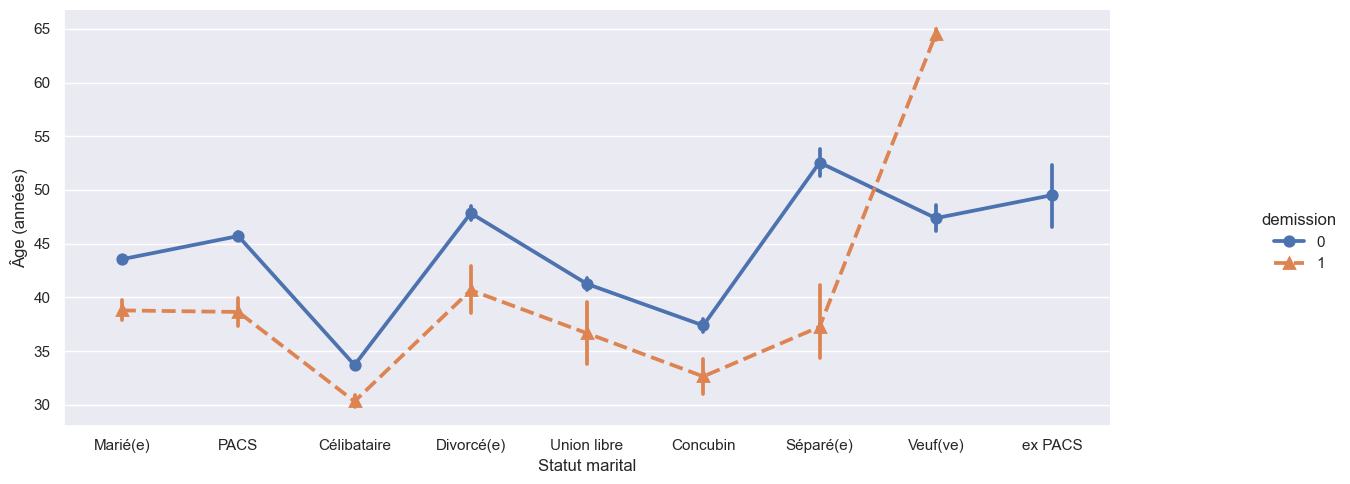

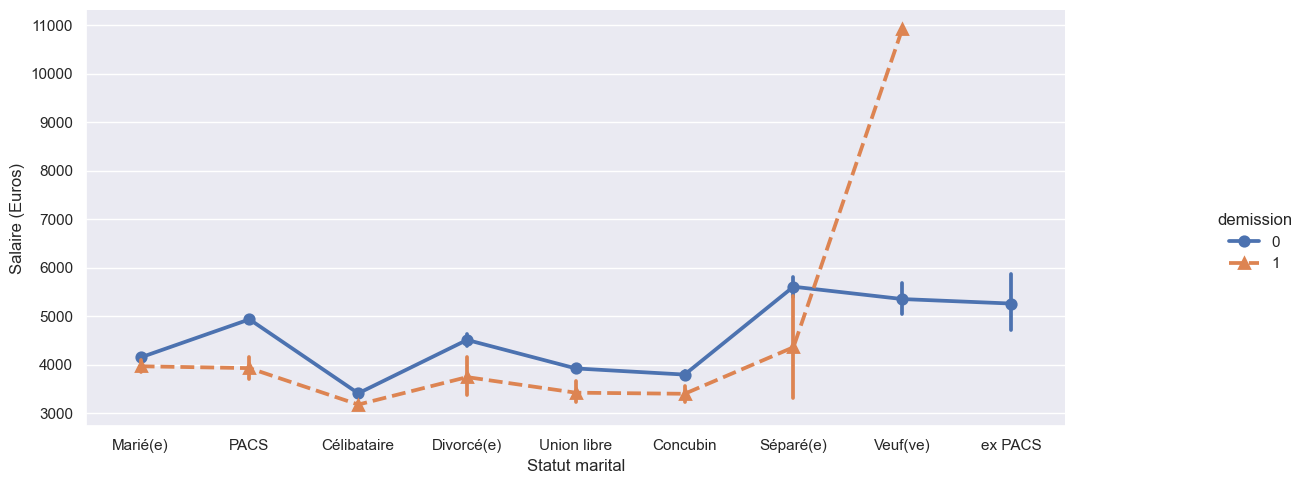

In [15]:
g = sns.catplot(
    data=df, x="Statut marital", y="Âge (années)", hue="demission",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = X["Statut marital"].unique())
g.set_xticklabels(X["Statut marital"].unique())
plt.gcf().set_size_inches(15, 5)
g = sns.catplot(
    data=df, x="Statut marital", y="Salaire (Euros)", hue="demission",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = X["Statut marital"].unique())
g.set_xticklabels(X["Statut marital"].unique())
plt.gcf().set_size_inches(15, 5)

Les célibataires, les divorcés et les séparés (avec une grosse variabilité) sont plus jeunes à démissionner. 

Le salairs n'est pas important pour expliquer la démission des mariés
Cas particulier des veufs (outliers)

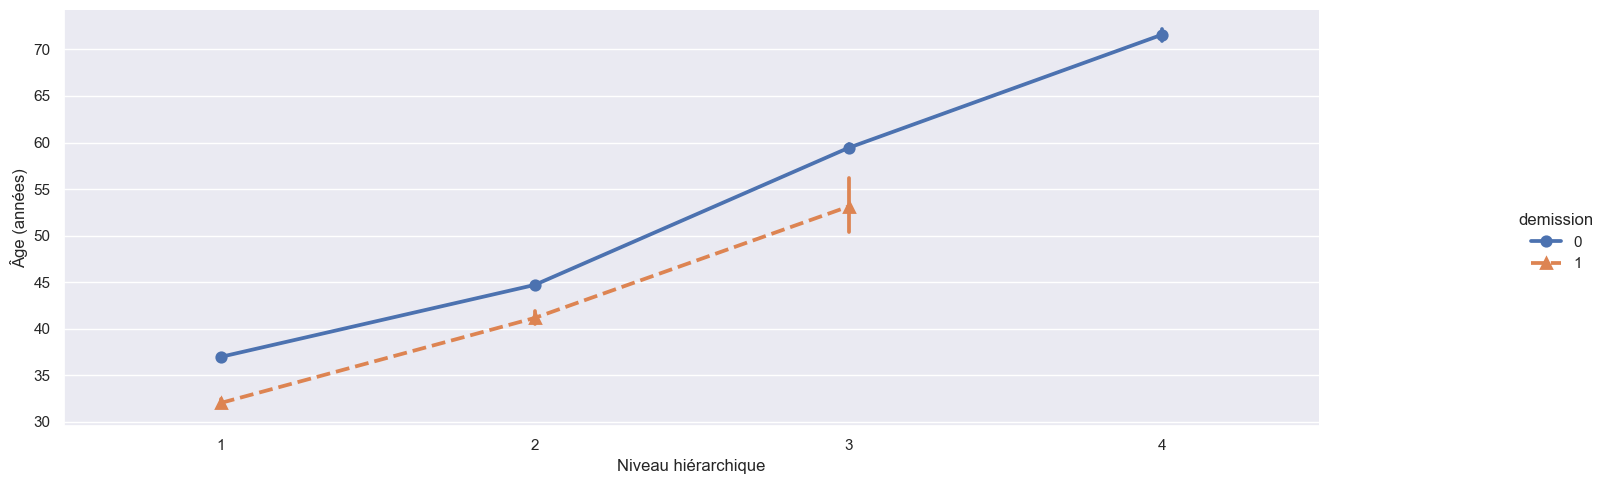

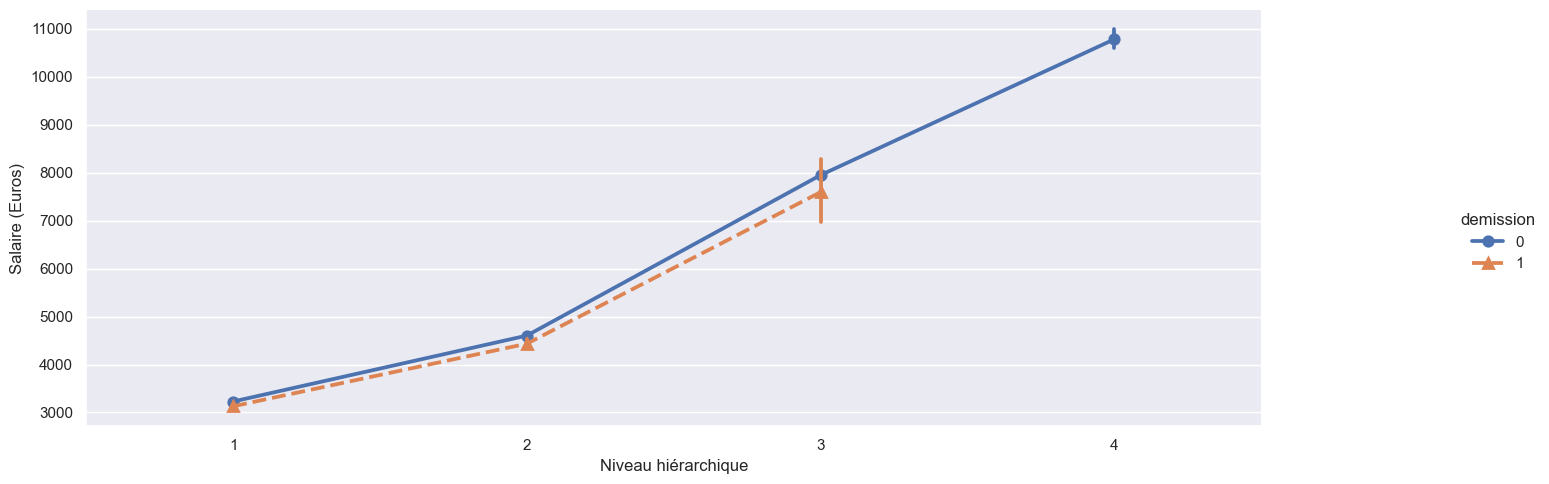

In [16]:
g = sns.catplot(
    data=df, x="Niveau hiérarchique", y="Âge (années)", hue="demission",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = X["Niveau hiérarchique"].unique())
g.set_xticklabels(X["Niveau hiérarchique"].unique())
plt.gcf().set_size_inches(18, 5)
g = sns.catplot(
    data=df, x="Niveau hiérarchique", y="Salaire (Euros)", hue="demission",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = X["Niveau hiérarchique"].unique())
g.set_xticklabels(X["Niveau hiérarchique"].unique())
plt.gcf().set_size_inches(18, 5)

A niveau hiérarchique équivalent, ceux qui démissionnent sont plus jeunes de 10 ans. Le salaire n'est pas un facteur qui oriente la décision de rester ou pas à niveau hiérarchique équivalent. Le niveua 4 ne démissionne pas

### Parcours d'un démissionnaire

Le démissionnaire est arrivé dans l’entreprise jeune (vers 25-30 ans), il a occupé un poste technique, support ou commercial (ex : IT, Business, Études & Technique) avec un salaire initial plutôt modeste (2500-4000€).


Quelques facteurs qui l'ont poussé à démissionner : 

- Salaire jugé trop faible par rapport au marché.
- Absence de reconnaissance ou d’évolution (promotion tardive ou inexistante).
- Situation personnelle :
    Célibataire → plus mobile, plus enclin à partir.
    Divorcé/séparé → recherche d’un nouveau départ professionnel.

Il a quitté l’entreprise vers 30-35 ans.


### Parcours d'un non démissionnaire

Le non démissionnaire est arrivé en entreprise jeune (25-30 ans) ou après quelques expériences professionnelles (30-35 ans). Il travaille dans des secteurs plus stables (Management, Développement Immobilier, Matériel/Équipement) avec un salaire initial légèrement plus élevé que les démissionnaires (ou progression plus rapide).

Sa carrière a progressé comme suit:
- Au bout de 3-5 ans, reçoit des augmentations régulières et/ou une promotion.
- Vers 35-40 ans, atteint un niveau intermédiaire avec un salaire confortable (4500-6000€+).
- Bénéficie de plus de stabilité personnelle : souvent marié/PACS, enfants → réduit la mobilité.

A long terme, il a atteint des postes seniors/management après 10-15 ans d’ancienneté et a la possibilité de terminer sa carrière dans l’entreprise, surtout si le salaire continue de progresser.

# Apprentissage automatique

Un modèle transparent est un modèle dont les décisions et les prédictions peuvent être facilement interprétées et comprises par les humains. Cela inclut des modèles comme la régression linéaire, les arbres de décision ou les modèles additifs généralisés (GAM), où l'impact de chaque variable sur le résultat peut être clairement identifié et expliqué.

### One Hot Encoding

In [17]:
# Utilisation de get_dummies pour les colonnes "Famille d'emploi" et "Statut marital"
dummies = pd.get_dummies(X[["Famille d'emploi", "Statut marital"]], prefix=['Famille', 'Statut'])

# Insertion des colonnes créées dans le dataframe original
data = pd.concat([X, dummies], axis=1)

# Suppression des colonnes originales
data = data.drop(["Famille d'emploi", "Statut marital"], axis=1)

X = data

# Affichage du dataframe modifié
data.head()

,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Véhicule,...,Famille_Support,Statut_Concubin,Statut_Célibataire,Statut_Divorcé(e),Statut_Marié(e),Statut_PACS,Statut_Séparé(e),Statut_Union libre,Statut_Veuf(ve),Statut_ex PACS
0,8.510000,7.900000,0.910000,0.970000,27,30,1,1,3199,0,...,False,False,False,False,True,False,False,False,False,False
1,35.119999,22.690001,14.830000,16.299999,7,45,1,2,3861,1,...,False,False,False,False,True,False,False,False,False,False
2,25.299999,22.139999,17.309999,17.790001,28,49,1,2,4324,1,...,False,False,False,False,False,True,False,False,False,False
3,5.240000,5.100000,1.020000,1.750000,27,24,0,1,2641,0,...,False,False,True,False,False,False,False,False,False,False
4,35.919998,22.840000,8.050000,9.000000,7,46,1,2,5072,1,...,False,False,False,False,True,False,False,False,False,False


### Regression linéaire

In [18]:
# REG LINEAIRE MODELE
# Initialize the Linear Regression model
model1 = LinearRegression()

# Train the model
model1.fit(X, y)

# Print the coefficients
print("Coefficients:", model1.coef_)
print("Intercept:", model1.intercept_)

Coefficients: [ 2.77261966e-04  7.96185503e-04 -6.57014818e-04 -8.79568000e-05
 -5.96527935e-05 -2.01358753e-03 -2.20097958e-02 -2.08593771e-03
  5.63956519e-06 -6.40750958e-04  5.92130225e-03 -6.82973862e-03
  4.43227412e-03 -5.08999543e-03 -1.13110881e-02  5.36840623e-03
  9.51324937e-03 -2.00440984e-03  4.77928028e-03  5.81067048e-03
 -2.06796745e-03  6.35940595e-03  5.13087883e-03  1.57194084e-03
  8.67986083e-04 -6.49800688e-03 -1.59541881e-02]
Intercept: 0.09402515201459646


In [19]:
# T VALUES
# Calculate standard error and t-value for each feature
std_y = np.std(y)
results = []

for feature in X.columns:
    std_x = np.sqrt(std_y**2 / sum((X[feature] - X[feature].mean())**2))
    t_value = np.abs(model1.coef_[X.columns.get_loc(feature)] / std_x)
    
    results.append({
        'Feature': feature,
        'Weight': model1.coef_[X.columns.get_loc(feature)],
        'Standard Error': std_x,
        't_value': t_value
    })

# Create a DataFrame to store the results
results_df = pd.DataFrame(results)
# Display the DataFrame
print(results_df)

                             Feature    Weight  Standard Error    t_value
0          Dernière promotion (mois)  0.000277    4.445081e-05   6.237501
1       Dernière augmentation (mois)  0.000796    1.501197e-04   5.303671
2          Début de contrat (années) -0.000657    1.893586e-04   3.469686
3         Ancienneté groupe (années) -0.000088    1.229470e-04   0.715404
4                      Etablissement -0.000060    1.219305e-04   0.489236
5                       Âge (années) -0.002014    1.029013e-04  19.568136
6                             Parent -0.022010    2.526196e-03   8.712625
7                Niveau hiérarchique -0.002086    1.722789e-03   1.210791
8                    Salaire (Euros)  0.000006    6.836655e-07   8.249012
9                           Véhicule -0.000641    2.265448e-03   0.282836
10       Famille_Commercial/Business  0.005921    4.427367e-03   1.337432
11  Famille_Développement Immobilier -0.006830    8.881970e-03   0.768944
12        Famille_Etudes & Technique  

Tri des features par t-value croissante

| Feature                      | Weight    | t-value | Interprétation                                                                                                                                                                |   
|------------------------------|-----------|---------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Âge (années)                 | -0.002014 | 19.57   | Plus on est âgé, moins on démissionne. Les jeunes partent plus.                                                                                                               |   
| Parent                       | -0.022010 | 8.71    | Avoir des enfants réduit fortement la probabilité de démission.                                                                                                               |   
| Dernière promotion (mois)    | 0.000277  | 6.24    | Plus la dernière promotion est ancienne, plus le risque de démission augmente.                                                                                                |   
| Dernière augmentation (mois) | 0.000796  | 5.30    | Si l’augmentation salariale remonte à loin, le risque de départ augmente.                                                                                                     |   
| Salaire (Euros)              | 0.000006  | 8.25    | Plus le salaire est élevé, plus la probabilité de démission augmente. Cela peut sembler contre-intuitif, mais cela pourrait être lié à des opportunités de marché meilleures, notamment pour les top employés de l'entreprise. |   
| Famille_Production           | 0.009513  | 4.18    | Les employés dans la production ont un risque plus élevé de démissionner.                                                                                                     |   
| Statut_Célibataire           | 0.005811  | 2.10    | Les célibataires ont une plus forte probabilité de démissionner.                                                                                                              |   
| Statut_Marié(e)              | 0.006359  | 2.78    | Les mariés ont aussi une tendance à démissionner, mais moindre que les célibataires.                                                                                          |   

### Arbre de décision

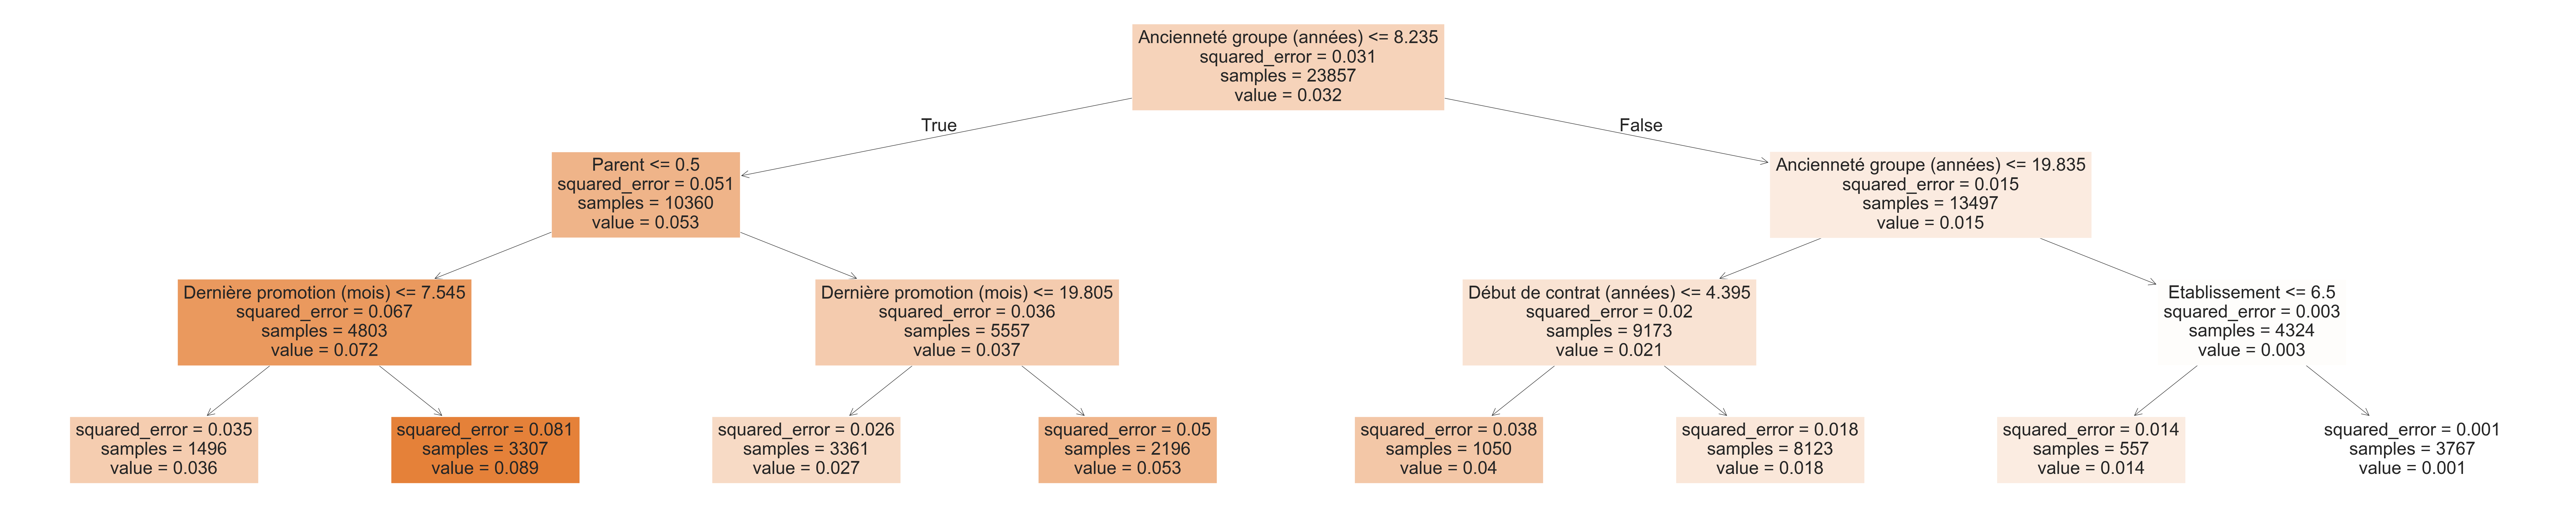

In [20]:
# ARBRE DE DECISION MODELE
%matplotlib inline

model2= tree.DecisionTreeRegressor(max_depth=3)
model2.fit(X, y)


plt.figure(figsize=(100,20))
tree.plot_tree(model2, feature_names=X.columns, filled=True)
plt.show()

In [21]:
# CHEMIN D'UNE DEMISSION
# Sélectionner un démissionnaire aléatoire
random_resigner_index = df[df["demission"] == 1].sample(n=1, random_state=1).index[0]

# Obtenir le chemin de décision pour ce démissionnaire
node_indicator = model2.decision_path(X.iloc[[random_resigner_index]])

# Obtenir les ids des nœuds que l'instance traverse
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

# Afficher le chemin de décision
print(f"Decision path for the resigner at index {random_resigner_index}:")
for node_id in node_index:
    if node_id == node_index[-1]:
        print(f"Node {node_id}: Leaf node")
    else:
        feature = model2.tree_.feature[node_id]
        threshold = model2.tree_.threshold[node_id]
        if X.iloc[random_resigner_index, feature] <= threshold:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        print(f"Node {node_id}: (X[{feature}] = {X.columns[feature]}) {threshold_sign} {threshold:.2f}")

Decision path for the resigner at index 22633:
Node 0: (X[3] = Ancienneté groupe (années)) <= 8.23
Node 1: (X[6] = Parent) <= 0.50
Node 2: (X[0] = Dernière promotion (mois)) > 7.55
Node 4: Leaf node


Le chemin de décision montre un employé démissionnaire aléaotoire. Il a démissionné car il avait moins de 8.23 ans d’ancienneté, n’avait pas d’enfants, et n’avait pas été promu depuis plus de 7.55 mois. Ces critères indiquent un profil jeune, sans attache familiale, et avec peu d’évolution récente, ce qui correspond aux principaux facteurs de démission identifiés.

Feature: 0, Score: 0.21950
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.02595
Feature: 3, Score: 0.56191
Feature: 4, Score: 0.00499
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.18765
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000


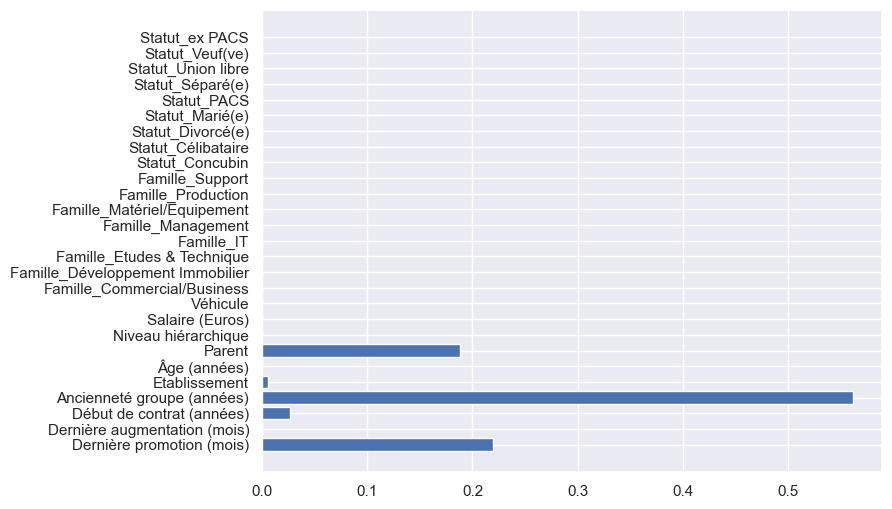

In [22]:
# FEATURE IMPORTANCE
# get importance
importance = model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance with feature names
plt.figure(figsize=(8, 6))
plt.barh(X.columns, importance)
plt.grid(True)
plt.show()

Le facteur le plus discriminant dans l'arbre de décision est l'ancienneté dans le groupe, le fait d'être parent ou non, et enfin la dernière promotion

### GAM

In [23]:
# GAM MODELE
# # Initialize the GAM model
# Construire un dictionnaire qui associe chaque terme "s(3)" ou autre au nom d'une colonne de X (dans l'ordre)
terms_dict = {f"s({i})" if i < 9 else f"f({i})": col for i, col in enumerate(X.columns)}
terms_dict["f(6)"] = terms_dict.pop("s(6)")

# Initialize the GAM model
model3 = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + s(7) + s(8) + f(9) + f(10) + f(11)
    + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23)
    + f(24) + f(25) + f(26)
)

# Train the model
model3.fit(X, y)

# Print the summary of the model
print(model3.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    127.5996
Link Function:                     IdentityLink Log Likelihood:                               -334879.2934
Number of Samples:                        23857 AIC:                                           670015.7859
                                                AICc:                                          670017.1907
                                                GCV:                                                0.0302
                                                Scale:                                              0.0299
                                                Pseudo R-Squared:                                   0.0292
Feature Function                  Lam

C:\Users\guill\AppData\Local\Temp\ipykernel_28312\2894545123.py:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(model3.summary())


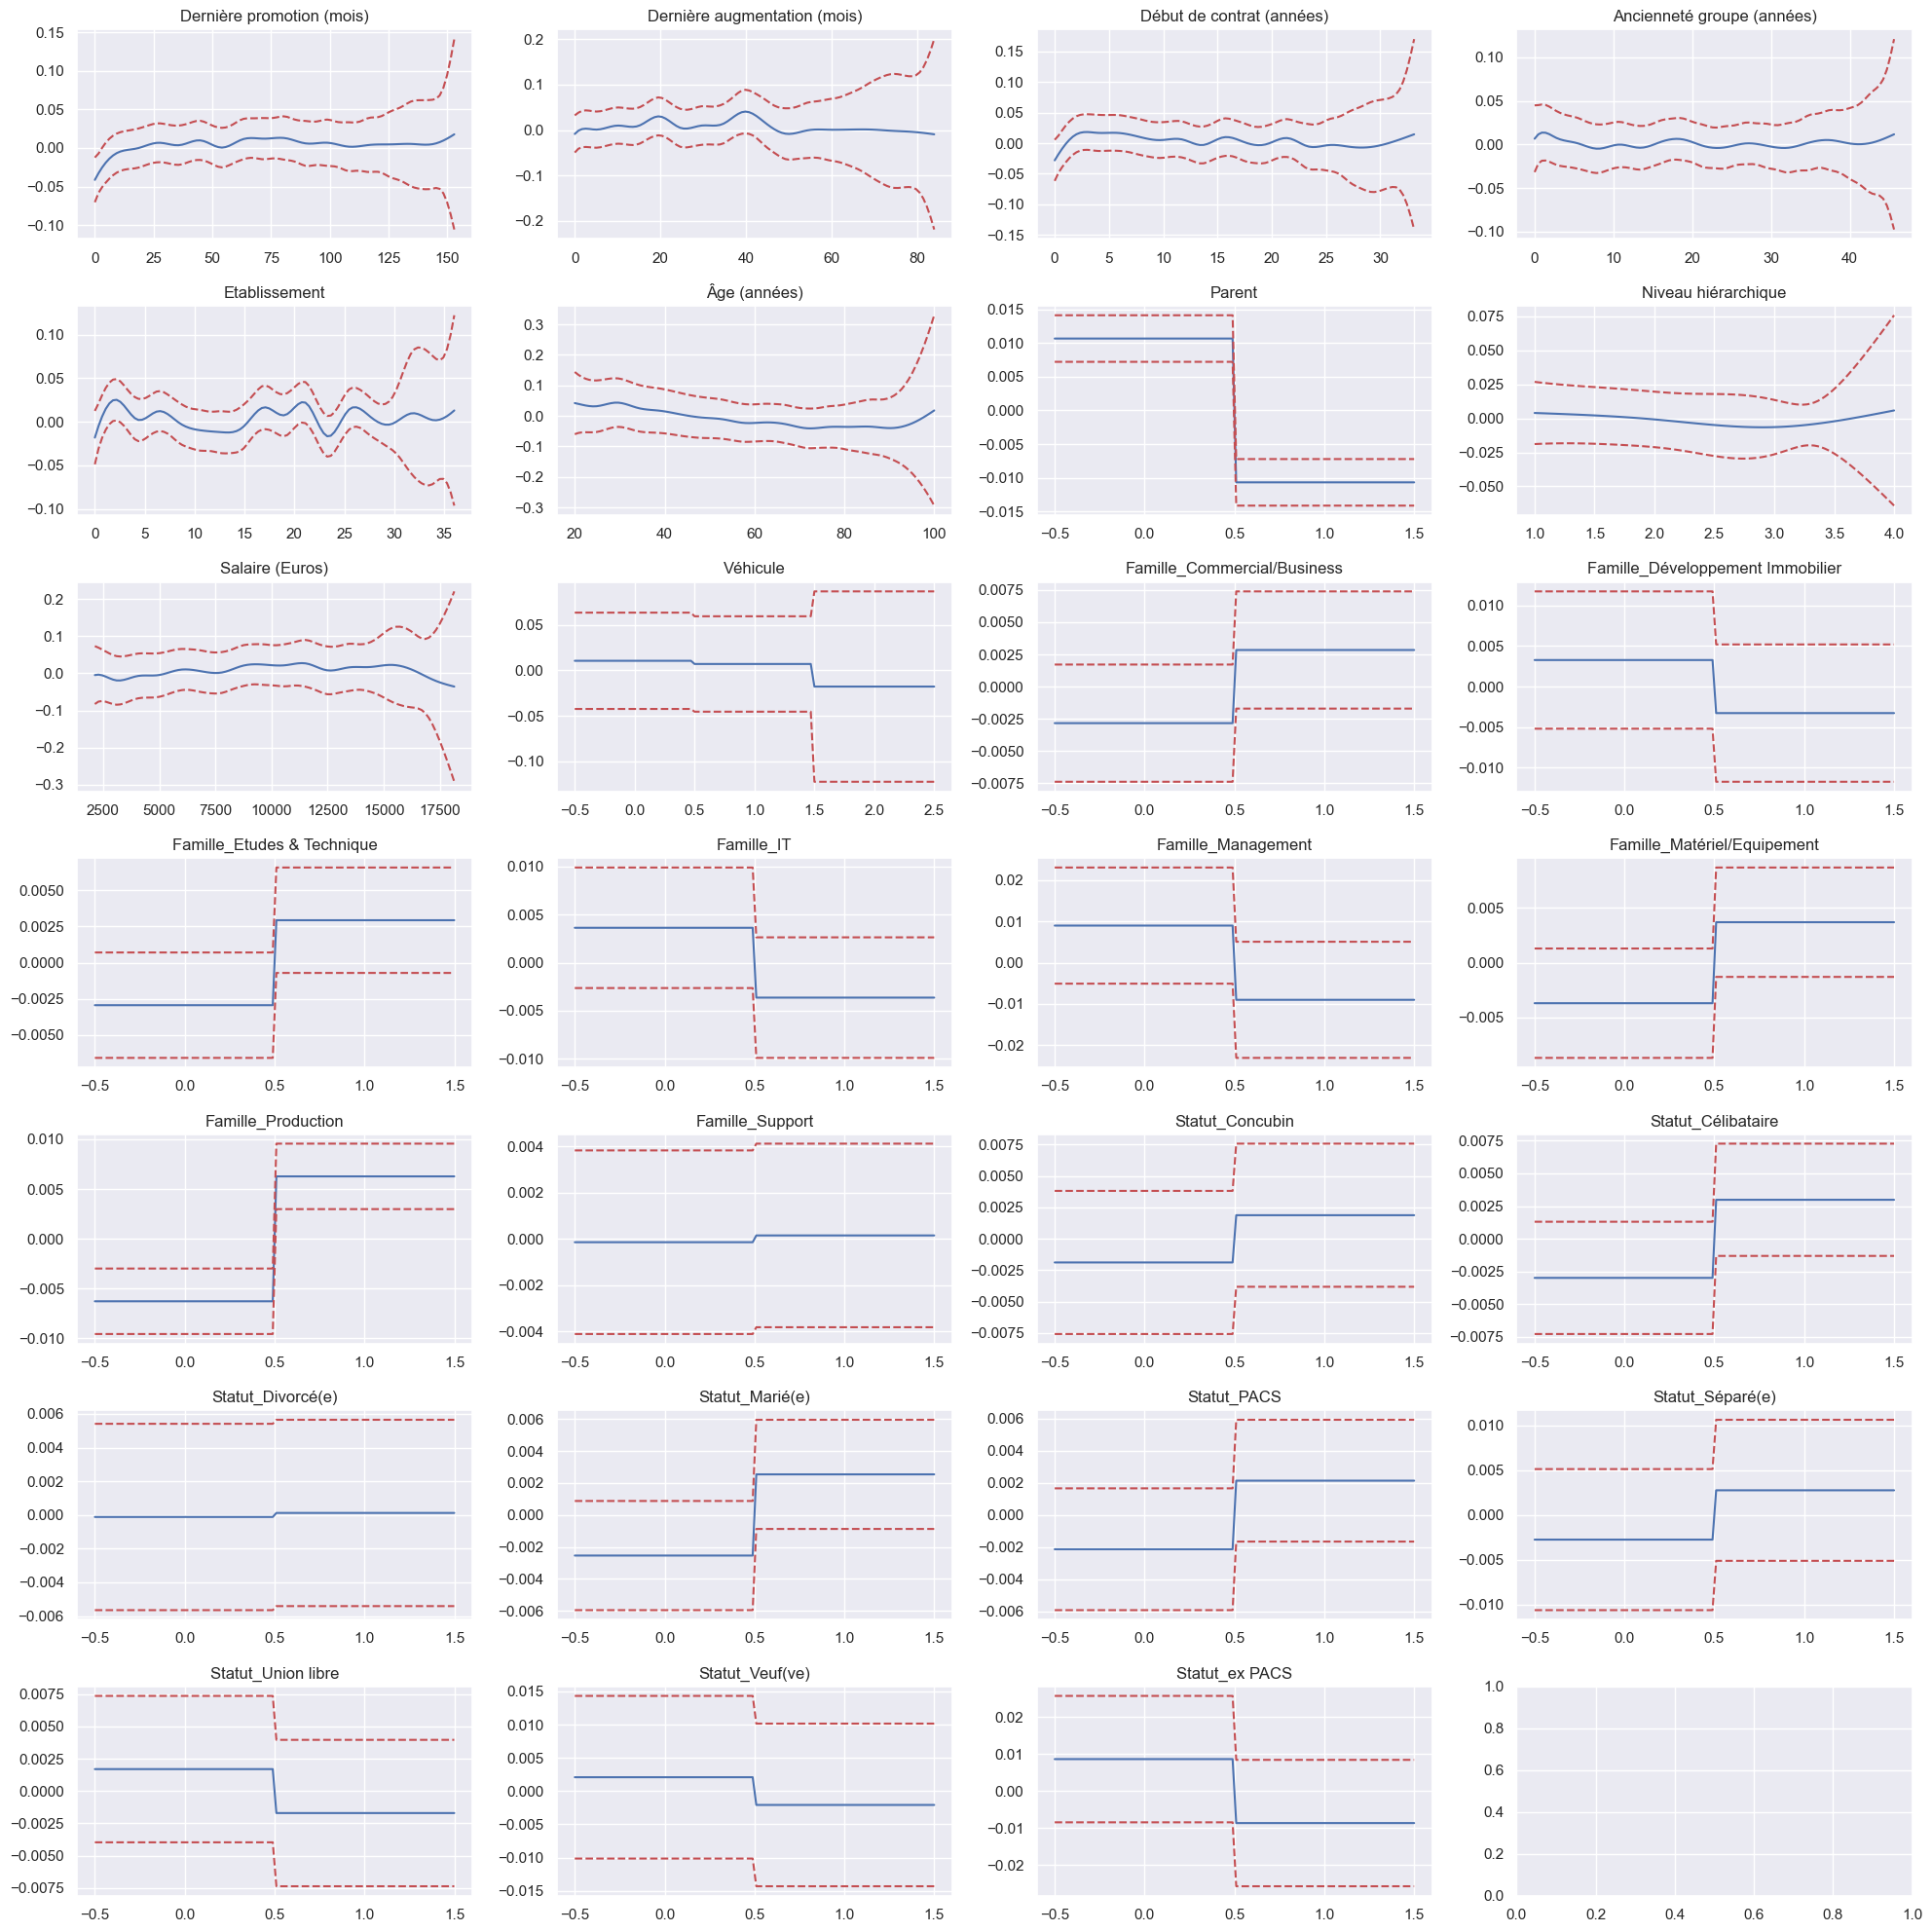

In [24]:
#VISUALISATION
fig, axs = plt.subplots(7, 4, figsize=(20, 20))  # Ajustez les dimensions selon le nombre de termes
axs = axs.flatten()

for i, term in enumerate(model3.terms):
    if term.isintercept:
        continue

    XX = model3.generate_X_grid(term=i)
    pdep, confi = model3.partial_dependence(term=i, X=XX, width=0.95)

    axs[i].plot(XX[:, term.feature], pdep)
    axs[i].plot(XX[:, term.feature], confi, c='r', ls='--')
    axs[i].set_title(terms_dict[repr(term)])

plt.tight_layout()
plt.show()

- Plus l’ancienneté et l'âge augmentent, plus le risque de démission diminue.
- Ne pas être promu ni augmenté récemment est un facteur de départ important.
- Être parent et marié réduit considérablement la probabilité de démission.
- Les employés en production et les célibataires sont les plus enclins à partir.
- Un salaire élevé réduit le risque de départ, sauf pour les très hauts salaires qui peuvent être recrutés ailleurs.

# Explication post-hoc

Nous choisissons d'exploiter une méthode post-hoc sur un modèle qui n'est pas transparent. Nous choisissons d'utiliser XGBoost et Shap

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# Create the model
modelxgb=XGBClassifier()

# Fit the model
modelxgb.fit(X, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
import shap

# SHAP explainer
explainer = shap.Explainer(modelxgb, X.astype('float64'))
shap_values = explainer(X)

 99%|===================| 23539/23857 [01:00<00:00]        

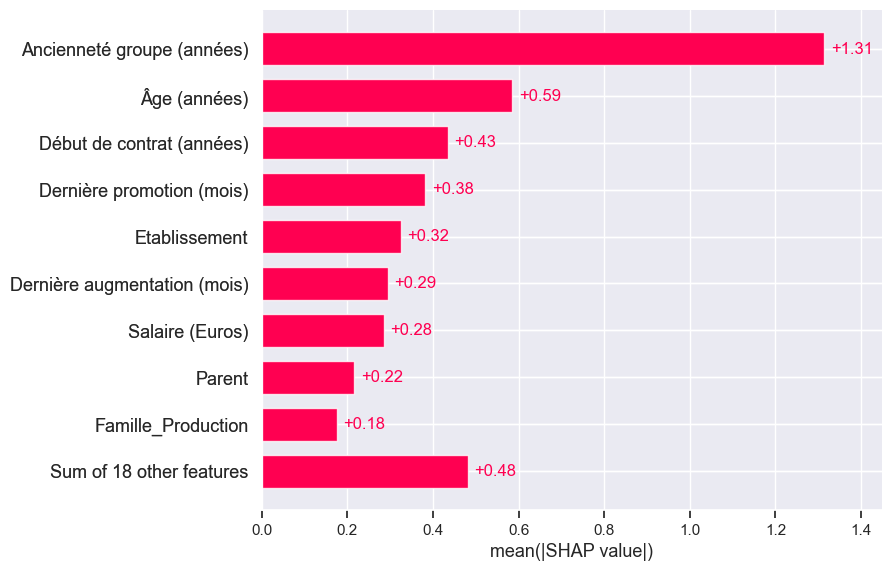

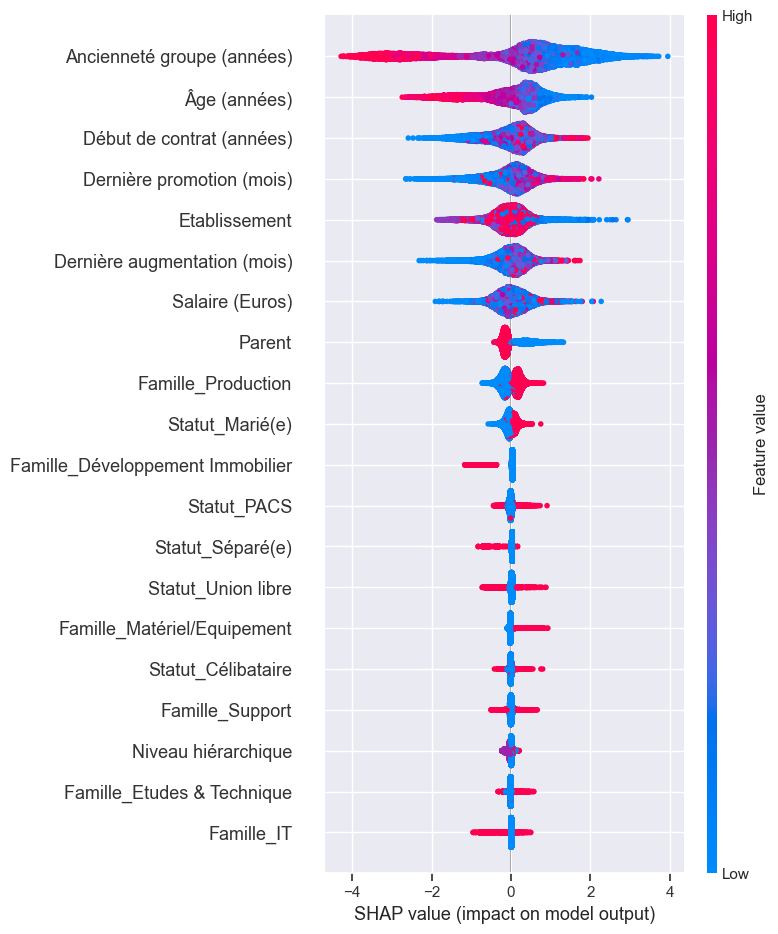

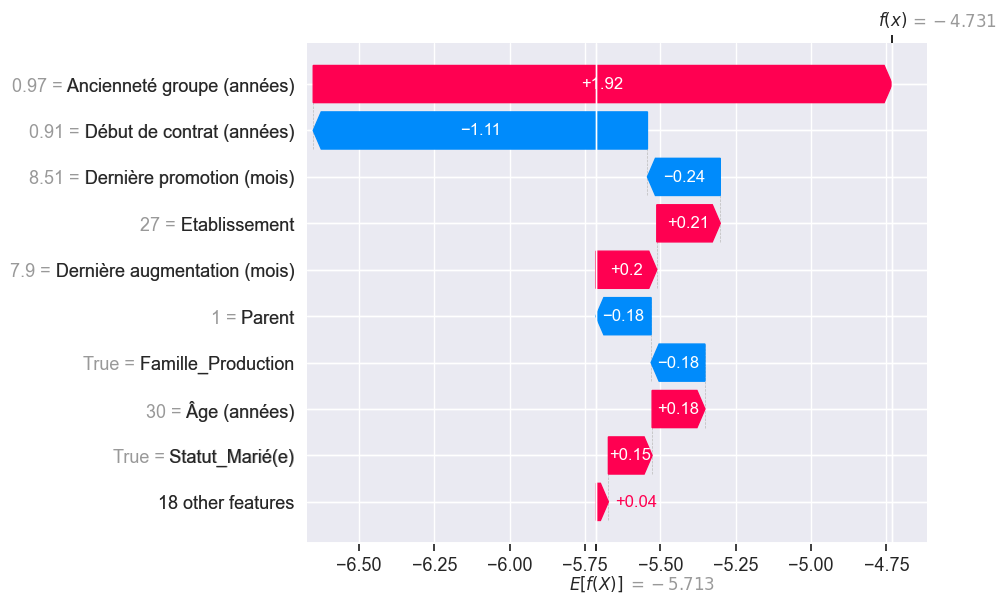

In [27]:
# Shap plots 
shap.plots.bar(shap_values, max_display=10)
shap.summary_plot(shap_values, X)
shap.plots.waterfall(shap_values[0])

Une première exécution de Shap sur un modèle XGB fité sur le data set entier permet de déterminer l'importance des features dans le modèle.

Avec le barplot, on voit que l'âge, l'ancienneté dans le groupe, la date de début de contrat et la date de dernière promotion sont les features les plus importantes. En moyenne, elle ont une VA de valeur de shapley comprise entre 0.3 et 1.31, contre moins de 0.3 pour toutes les autres features.

Le beeswarm permet de préciser cette analyse : 
- un âge élevé a peut de chance de démissionner, idem pour l'ancienneté du groupe. Ces deux features ne sont pas centrées autour de la médiane avec une surrepésentation de valeurs faibles (ie de jeunes employés) qui démissionnent et d'employés agés qui restent.
- une date de début de contrat ou de dernière promotion élevée tend à faire démissionner, alors que des contrats ou promotions récents tendent à indiquer ques les employer ne démisionnent pas. Les valeurs faibles ont une valeur de shapley plus faible, donc une promotion récente joue fortement dans la balance pour faire rester un employer.

L'analyse waterfall du premier élément, dont on prédit la démission (prédiction de 0.05), montre que l'ancienneté et l'age font augmenter la valeur de base 0.37, alors que la date de début de contrat et la dernière promotion font baisser la valeur de 0.23 en cumulé.

Une cross validation est réalisée pour obtenir un benchmark de notre modèle avant la suppression des features inutiles

In [28]:
# Cross-validation
cv_scores = cross_validate(modelxgb, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Acc : ", np.abs(cv_scores['test_accuracy'].mean()))
print("Pre : ", np.abs(cv_scores['test_precision'].mean()))
print("Rec : ", np.abs(cv_scores['test_recall'].mean()))
print("F1 : ", np.abs(cv_scores['test_f1'].mean()))

Cross-validation scores: {'fit_time': array([0.17865372, 0.1810472 , 0.17624617, 0.1825242 , 0.18572021]), 'score_time': array([0.03091121, 0.02459669, 0.02631617, 0.02553892, 0.02481985]), 'test_accuracy': array([0.96668064, 0.96751886, 0.96793125, 0.96772165, 0.96730245]), 'test_precision': array([0.16666667, 0.3       , 0.375     , 0.33333333, 0.14285714]), 'test_recall': array([0.01324503, 0.01986755, 0.01986755, 0.01986755, 0.00662252]), 'test_f1': array([0.02453988, 0.03726708, 0.03773585, 0.0375    , 0.01265823])}
Acc :  0.9674309704675302
Pre :  0.26357142857142857
Rec :  0.01589403973509934
F1 :  0.029940206990132036


# Apprentissage automatique sur un jeu de données réduit

D'après l'étude post-hoc ci-dessus, nous choisissons de conserver les colonnes suivantes : 
- Âge
- Ancienneté groupe
- Date début de contrat
- Date de dernière promotion

In [29]:
X_red = X[['Âge (années)', 'Ancienneté groupe (années)', 'Début de contrat (années)', 'Dernière promotion (mois)']]


In [30]:
# Cross-validation
cv_scores_red = cross_validate(modelxgb, X_red, y, cv=5, scoring=['accuracy', 'precision', 'recall','f1'])

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores_red)
print("Acc : ", np.abs(cv_scores_red['test_accuracy'].mean()))
print("Pre : ", np.abs(cv_scores_red['test_precision'].mean()))
print("Rec : ", np.abs(cv_scores_red['test_recall'].mean()))
print("F1 : ", np.abs(cv_scores_red['test_f1'].mean()))

Cross-validation scores: {'fit_time': array([0.11465883, 0.09455538, 0.10401368, 0.10437036, 0.09701061]), 'score_time': array([0.01720262, 0.01937652, 0.01776576, 0.01703715, 0.04333663]), 'test_accuracy': array([0.96772842, 0.96772842, 0.96772165, 0.96814085, 0.96835045]), 'test_precision': array([0.        , 0.        , 0.        , 0.33333333, 0.        ]), 'test_recall': array([0.        , 0.        , 0.        , 0.00662252, 0.        ]), 'test_f1': array([0.        , 0.        , 0.        , 0.01298701, 0.        ])}
Acc :  0.9679339569552917
Pre :  0.06666666666666667
Rec :  0.0013245033112582781
F1 :  0.0025974025974025974


C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Les résultats obtenus sont légèrement meilleurs en réduisant le nombre de features, notamment sur la précision, le recall et le f1 score. En supprimant les features non pertinentes, le modèle se concentre sur les informations essentielles, réduisant ainsi le risque de sur-apprentissagee et favorisant la généralisation.

Une accruracy de 97% en Cross Validation avec 5 folds signifie que notre modèle est robuste et l'analyse réalisée avec Shap sur les features les plus importantes est correcte. Elle permet avec un iveau de qualité certain de prédire (ou tout du moins, de cerner les comportements) les démissionnaires des non démissionnaires de l'entreprise.